# Assignment -3
## Gauranga Kumar Baishya, MDS202325
## Dipanjoy Saha, MDS202321

# Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
import warnings
from sklearn.exceptions import ConvergenceWarning

# Assignment: Part 1

# Body

## About the data

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


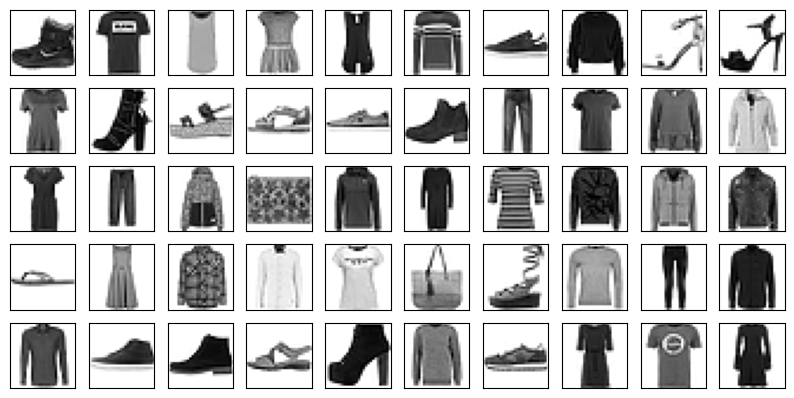

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

## K = 50

### Step 0

What does Logistic Regression predict in supervised learning?

In [ ]:
nsamples, nx, ny = train_images.shape
d2_train = train_images.reshape((nsamples,nx*ny))
nsamples, nx, ny = test_images.shape
d2_test = test_images.reshape((nsamples,nx*ny))

warnings.filterwarnings("ignore", category=ConvergenceWarning)
log_reg = LogisticRegression()
log_reg.fit(d2_train, train_labels)

score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression =", score)

Raw score on logistic regression = 0.8412


### Step 1
Let’s train a Logistic Regression model on a sample of 50 labeled instances from the digits dataset. What is the performance of this model on the test set?
The accuracy is just 65.36%. It should come as no surprise that this is much lower than earlier, when we trained the model on the full training set.


In [ ]:
nsamples, nx, ny = train_images.shape
d2_train = train_images.reshape((nsamples,nx*ny))
nsamples, nx, ny = test_images.shape
d2_test = test_images.reshape((nsamples,nx*ny))

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
n_labeled = 50
log_reg = LogisticRegression()
log_reg.fit(d2_train[:n_labeled], train_labels[:n_labeled])

LogisticRegression()

In [ ]:
score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression on only 50 training examples =", score)

Raw score on logistic regression on only 50 training examples = 0.6536


### Step 2
Let’s see how we can do better. First, let’s cluster the training set into 50 clusters. Then for each cluster, let’s find the image closest to the centroid. We will call these images the representative images:

In [ ]:
kmeans = KMeans(n_clusters=50)
X_digits_dist = kmeans.fit_transform(d2_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = d2_train[representative_digit_idx]

### Step 3
Let’s look at each image and manually label it:

In [ ]:
y_representative_digits = train_labels[representative_digit_idx] #class_names = [0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
                                                                               # 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot']

### Step 4
Now we have a dataset with just 50 labeled instances, but instead of being random instances, each of them is a representative image of its cluster. Let’s see if the performance is any better.


By utilizing representative images from clusters as labeled instances in the training dataset instead of random samples, the performance of the model can be improved. These representative images are carefully selected to encapsulate the essential characteristics and variations within each cluster, serving as more informative prototypes for their respective groups.

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_representative_digits, y_representative_digits)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after using the representative images for training:", score)

Accuracy score after using the representative images for training: 0.6422


### Step 5
what if we propagated the labels to all the other instances in the same cluster? This is called label propagation:

We propagate the labels of representative digits to all instances within the same cluster obtained through K-Means clustering.  

Then, we train the model again and look at its performance:

In [ ]:
y_train_propagated = np.empty(len(d2_train), dtype=np.int32)
for i in range(50):
  y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
log_reg = LogisticRegression()
log_reg.fit(d2_train, y_train_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating the representative images for training:", score)

Accuracy score after propagating the representative images for training: 0.6456


### Step 6
We propagated each representative instance’s label to all the instances in the same cluster, including the instances located close to the cluster boundaries, which are more likely to be mislabeled. Let’s see what happens if we only propagate the labels to the 20% of the instances that are closest to the centroids:

In [ ]:
percentile_closest = 100
X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
for i in range(50):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  X_cluster_dist[in_cluster & above_cutoff] = -1
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = d2_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating 20% of the representative images for training:", score)

Accuracy score after propagating 20% of the representative images for training: 0.6456


### Plot of Accuracy Scores for various values of percentile_values

In [ ]:
percentile_values = np.arange(0, 101, 10)  # Percentile values from 1 to 100 with steps of 10
accuracy_scores = []

for percentile_closest in percentile_values:
    X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
    for i in range(50):
        in_cluster = (kmeans.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1
    partially_propagated = (X_cluster_dist != -1)
    X_train_partially_propagated = d2_train[partially_propagated]
    y_train_partially_propagated = y_train_propagated[partially_propagated]

    log_reg = LogisticRegression()
    log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

    score = log_reg.score(d2_test, test_labels)
    accuracy_scores.append(score)

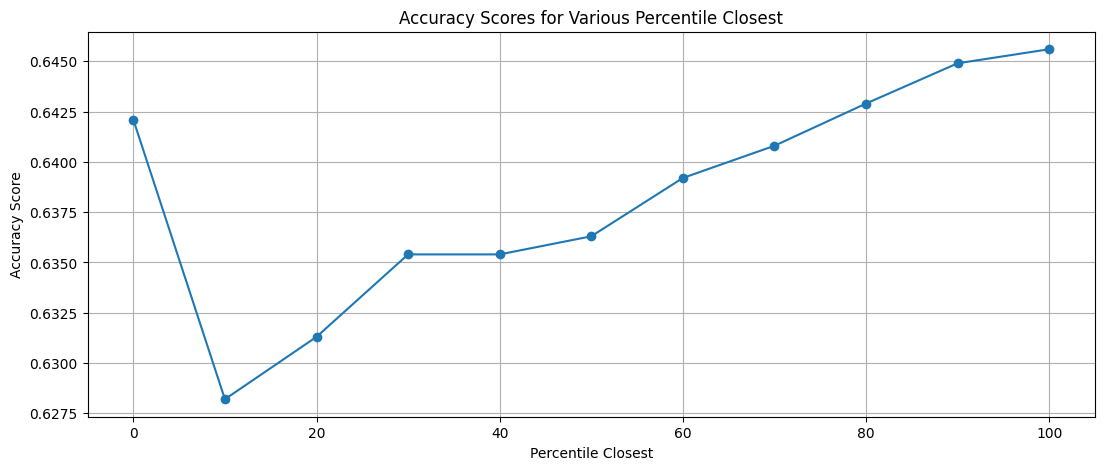

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(percentile_values, accuracy_scores, marker='o', linestyle='-')
plt.title('Accuracy Scores for Various Percentile Closest')
plt.xlabel('Percentile Closest')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

## K = 25

### Step 0

What does Logistic Regression predict in supervised learning?

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
nsamples, nx, ny = train_images.shape
d2_train = train_images.reshape((nsamples,nx*ny))
nsamples, nx, ny = test_images.shape
d2_test = test_images.reshape((nsamples,nx*ny))

warnings.filterwarnings("ignore", category=ConvergenceWarning)
log_reg = LogisticRegression()
log_reg.fit(d2_train, train_labels)

score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression on the whole dataset =", score)

Raw score on logistic regression on the whole dataset = 0.8412


### Step 1
Let’s train a Logistic Regression model on a sample of 25 labeled instances from the digits dataset. What is the performance of this model on the test set?
The accuracy is just 54.33%. It should come as no surprise that this is much lower than earlier, when we trained the model on the full training set.


In [ ]:
nsamples, nx, ny = train_images.shape
d2_train = train_images.reshape((nsamples,nx*ny))
nsamples, nx, ny = test_images.shape
d2_test = test_images.reshape((nsamples,nx*ny))

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
n_labeled = 25
log_reg = LogisticRegression()
log_reg.fit(d2_train[:n_labeled], train_labels[:n_labeled])

LogisticRegression()

In [ ]:
score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression on only 25 training examples =", score)

Raw score on logistic regression on only 25 training examples = 0.5433


### Step 2
Let’s see how we can do better. First, let’s cluster the training set into 25 clusters. Then for each cluster, let’s find the image closest to the centroid. We will call these images the representative images:

In [ ]:
kmeans = KMeans(n_clusters=25)
X_digits_dist = kmeans.fit_transform(d2_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = d2_train[representative_digit_idx]

### Step 3
Let’s look at each image and manually label it:

In [ ]:
y_representative_digits = train_labels[representative_digit_idx] #class_names = [0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
                                                                               # 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot']

### Step 4
Now we have a dataset with just 50 labeled instances, but instead of being random instances, each of them is a representative image of its cluster. Let’s see if the performance is any better.


By utilizing representative images from clusters as labeled instances in the training dataset instead of random samples, the performance of the model can be improved. These representative images are carefully selected to encapsulate the essential characteristics and variations within each cluster, serving as more informative prototypes for their respective groups.

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_representative_digits, y_representative_digits)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after using the representative images for training:", score)

Accuracy score after using the representative images for training: 0.6506


### Step 5
what if we propagated the labels to all the other instances in the same cluster? This is called label propagation:

We propagate the labels of representative digits to all instances within the same cluster obtained through K-Means clustering.  

Then, we train the model again and look at its performance:

In [ ]:
y_train_propagated = np.empty(len(d2_train), dtype=np.int32)
for i in range(25):
  y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
log_reg = LogisticRegression()
log_reg.fit(d2_train, y_train_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating (completely) the representative images for training:", score)

Accuracy score after propagating (completely) the representative images for training: 0.6507


### Step 6
We propagated each representative instance’s label to all the instances in the same cluster, including the instances located close to the cluster boundaries, which are more likely to be mislabeled. Let’s see what happens if we only propagate the labels to the 20% of the instances that are closest to the centroids:

In [ ]:
percentile_closest = 40
X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
for i in range(25):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  X_cluster_dist[in_cluster & above_cutoff] = -1
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = d2_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating 40% of the representative images for training:", score)

Accuracy score after propagating 40% of the representative images for training: 0.6367


### Plot of Accuracy Scores for various values of percentile_values

In [ ]:
percentile_values = np.arange(0, 101, 10)  # Percentile values from 1 to 100 with steps of 10
accuracy_scores = []

for percentile_closest in percentile_values:
    X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
    for i in range(25):
        in_cluster = (kmeans.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1
    partially_propagated = (X_cluster_dist != -1)
    X_train_partially_propagated = d2_train[partially_propagated]
    y_train_partially_propagated = y_train_propagated[partially_propagated]

    log_reg = LogisticRegression()
    log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

    score = log_reg.score(d2_test, test_labels)
    accuracy_scores.append(score)

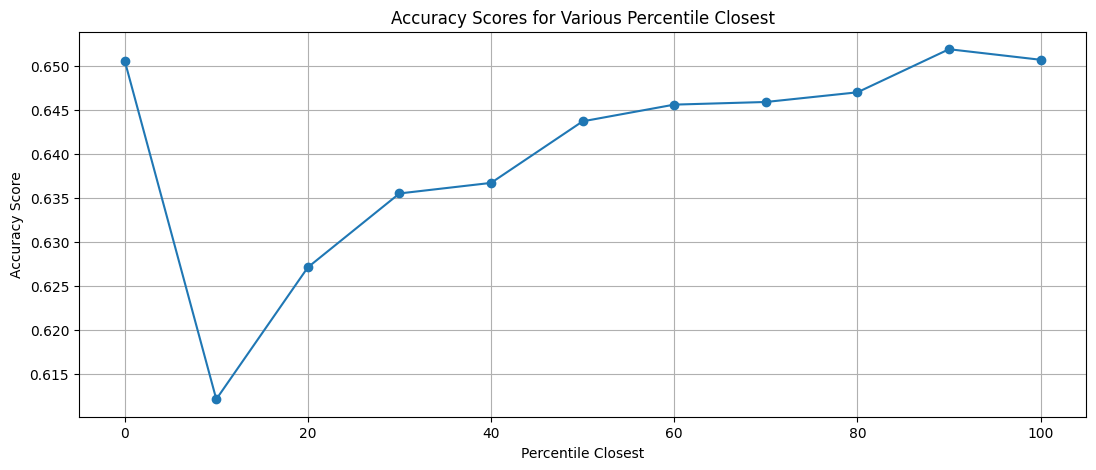

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(percentile_values, accuracy_scores, marker='o', linestyle='-')
plt.title('Accuracy Scores for Various Percentile Closest')
plt.xlabel('Percentile Closest')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

## K = 10

### Step 0

What does Logistic Regression predict in supervised learning?

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
nsamples, nx, ny = train_images.shape
d2_train = train_images.reshape((nsamples,nx*ny))
nsamples, nx, ny = test_images.shape
d2_test = test_images.reshape((nsamples,nx*ny))

warnings.filterwarnings("ignore", category=ConvergenceWarning)
log_reg = LogisticRegression()
log_reg.fit(d2_train, train_labels)

score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression on the whole dataset =", score)

Raw score on logistic regression on the whole dataset = 0.8412


### Step 1
Let’s train a Logistic Regression model on a sample of 10 labeled instances from the digits dataset. What is the performance of this model on the test set?
The accuracy is just 36.37%. It should come as no surprise that this is much lower than earlier, when we trained the model on the full training set.


In [ ]:
nsamples, nx, ny = train_images.shape
d2_train = train_images.reshape((nsamples,nx*ny))
nsamples, nx, ny = test_images.shape
d2_test = test_images.reshape((nsamples,nx*ny))

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
n_labeled = 10
log_reg = LogisticRegression()
log_reg.fit(d2_train[:n_labeled], train_labels[:n_labeled])

LogisticRegression()

In [ ]:
score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression on only 10 training examples =", score)

Raw score on logistic regression on only 10 training examples = 0.3637


### Step 2
Let’s see how we can do better. First, let’s cluster the training set into 25 clusters. Then for each cluster, let’s find the image closest to the centroid. We will call these images the representative images:

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
kmeans = KMeans(n_clusters=10)
X_digits_dist = kmeans.fit_transform(d2_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = d2_train[representative_digit_idx]

### Step 3
Let’s look at each image and manually label it:

In [ ]:
y_representative_digits = train_labels[representative_digit_idx] #class_names = [0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
                                                                               # 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot']

### Step 4
Now we have a dataset with just 50 labeled instances, but instead of being random instances, each of them is a representative image of its cluster. Let’s see if the performance is any better.


By utilizing representative images from clusters as labeled instances in the training dataset instead of random samples, the performance of the model can be improved. These representative images are carefully selected to encapsulate the essential characteristics and variations within each cluster, serving as more informative prototypes for their respective groups.

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_representative_digits, y_representative_digits)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after using only the representative images for training:", score)

Accuracy score after using only the representative images for training: 0.5697


### Step 5
what if we propagated the labels to all the other instances in the same cluster? This is called label propagation:

We propagate the labels of representative digits to all instances within the same cluster obtained through K-Means clustering.  

Then, we train the model again and look at its performance:

In [ ]:
y_train_propagated = np.empty(len(d2_train), dtype=np.int32)
for i in range(10):
  y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
log_reg = LogisticRegression()
log_reg.fit(d2_train, y_train_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating (completely) the representative images for training:", score)

Accuracy score after propagating (completely) the representative images for training: 0.5444


### Step 6
We propagated each representative instance’s label to all the instances in the same cluster, including the instances located close to the cluster boundaries, which are more likely to be mislabeled. Let’s see what happens if we only propagate the labels to the 40% of the instances that are closest to the centroids:

In [ ]:
percentile_closest = 40
X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
for i in range(10):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  X_cluster_dist[in_cluster & above_cutoff] = -1
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = d2_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating 40% of the representative images for training:", score)

Accuracy score after propagating 40% of the representative images for training: 0.5179


### Plot of Accuracy Scores for various values of percentile_values

In [ ]:
percentile_values = np.arange(0, 101, 10)  # Percentile values from 1 to 100 with steps of 10
accuracy_scores = []

for percentile_closest in percentile_values:
    X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
    for i in range(10):
        in_cluster = (kmeans.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1
    partially_propagated = (X_cluster_dist != -1)
    X_train_partially_propagated = d2_train[partially_propagated]
    y_train_partially_propagated = y_train_propagated[partially_propagated]

    log_reg = LogisticRegression()
    log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

    score = log_reg.score(d2_test, test_labels)
    accuracy_scores.append(score)

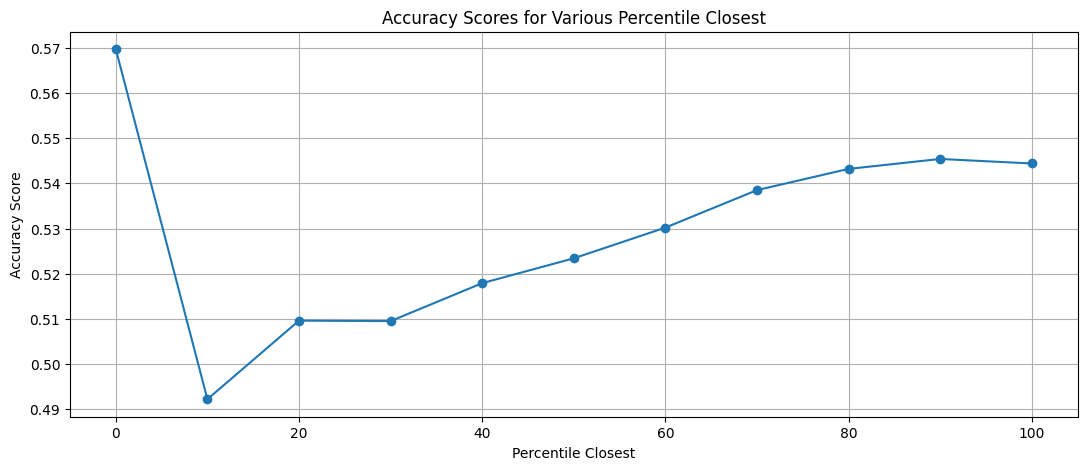

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(percentile_values, accuracy_scores, marker='o', linestyle='-')
plt.title('Accuracy Scores for Various Percentile Closest')
plt.xlabel('Percentile Closest')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

# Assignment: part 2

# Body

### Getting to know the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")
test = pd.read_csv("/content/drive/MyDrive/test.csv")
labels = pd.read_csv("/content/drive/MyDrive/labels.csv")
classes = pd.read_csv("/content/drive/MyDrive/classes.csv")

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,8,86,91,98,97,96,89,76,84,87,...,76,81,80,72,77,83,71,44,53,33
1,3,128,133,129,119,114,128,141,131,133,...,137,129,139,161,128,137,131,125,127,135
2,0,138,117,84,52,38,62,86,75,101,...,63,99,109,83,61,54,75,98,107,108
3,6,105,108,108,109,111,112,107,104,106,...,120,115,105,89,87,98,92,95,89,84
4,5,176,143,109,155,151,149,145,152,156,...,92,85,82,91,80,80,79,79,82,85


In [ ]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,198,225,234,229,230,228,214,244,107,...,209,222,211,196,216,206,192,212,242,254
1,1,34,35,30,17,16,22,11,42,137,...,36,41,32,33,34,37,33,36,35,37
2,4,113,176,239,250,247,231,177,181,178,...,70,85,158,189,150,168,148,181,154,54
3,3,151,129,173,182,140,119,120,115,112,...,136,118,126,130,124,119,134,126,121,122
4,7,186,159,233,255,255,227,140,110,113,...,131,149,108,87,120,131,138,137,137,139


### Preprocessing

In [ ]:
train_labels = []
for i in train['label']:
  train_labels.append(i)
train_labels = np.array(train_labels)
len(train_labels)

8519

In [ ]:
test_labels = []
for i in test['label']:
  test_labels.append(i)
test_labels = np.array(test_labels)
test_labels

array([5, 1, 4, ..., 7, 0, 2])

In [ ]:
len(train)

8519

In [ ]:
d2_train = [[] for _ in range(len(train))]
for col in train.columns[1:]:
  for i in range(len(train)):
      d2_train[i].append(train[col][i])
d2_train = np.array(d2_train)

In [ ]:
d2_train.shape

(8519, 784)

In [ ]:
d2_test = [[] for _ in range(len(test))]
for col in test.columns[1:]:
  for i in range(len(test)):
      d2_test[i].append(test[col][i])
d2_test = np.array(d2_test)

In [ ]:
d2_test.shape

(1065, 784)

## K = 50

### Step 0

What does Logistic Regression predict in supervised learning?

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
log_reg = LogisticRegression()
log_reg.fit(d2_train, train_labels)

score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression =", score)

Raw score on logistic regression = 0.4028169014084507


### Step 1
Let’s train a Logistic Regression model on a sample of 50 labeled instances from the digits dataset. What is the performance of this model on the test set?
The accuracy is just 65.36%. It should come as no surprise that this is much lower than earlier, when we trained the model on the full training set.


In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
n_labeled = 50
log_reg = LogisticRegression()
log_reg.fit(d2_train[:n_labeled], train_labels[:n_labeled])

LogisticRegression()

In [ ]:
score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression on only 50 training examples =", score)

Raw score on logistic regression on only 50 training examples = 0.17089201877934274


### Step 2
Let’s see how we can do better. First, let’s cluster the training set into 50 clusters. Then for each cluster, let’s find the image closest to the centroid. We will call these images the representative images:

In [ ]:
kmeans = KMeans(n_clusters=50)
X_digits_dist = kmeans.fit_transform(d2_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = d2_train[representative_digit_idx]

### Step 3
Let’s look at each image and manually label it:

In [ ]:
y_representative_digits = train_labels[representative_digit_idx]

### Step 4
Now we have a dataset with just 50 labeled instances, but instead of being random instances, each of them is a representative image of its cluster. Let’s see if the performance is any better.


By utilizing representative images from clusters as labeled instances in the training dataset instead of random samples, the performance of the model can be improved. These representative images are carefully selected to encapsulate the essential characteristics and variations within each cluster, serving as more informative prototypes for their respective groups.

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_representative_digits, y_representative_digits)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after using the representative images for training:", score)

Accuracy score after using the representative images for training: 0.2244131455399061


### Step 5
what if we propagated the labels to all the other instances in the same cluster? This is called label propagation:

We propagate the labels of representative digits to all instances within the same cluster obtained through K-Means clustering.  

Then, we train the model again and look at its performance:

In [ ]:
y_train_propagated = np.empty(len(d2_train), dtype=np.int32)
for i in range(50):
  y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
log_reg = LogisticRegression()
log_reg.fit(d2_train, y_train_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating the representative images for training:", score)

Accuracy score after propagating the representative images for training: 0.20657276995305165


### Step 6
We propagated each representative instance’s label to all the instances in the same cluster, including the instances located close to the cluster boundaries, which are more likely to be mislabeled. Let’s see what happens if we only propagate the labels to the 20% of the instances that are closest to the centroids:

In [ ]:
percentile_closest = 100
X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
for i in range(50):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  X_cluster_dist[in_cluster & above_cutoff] = -1
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = d2_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating 20% of the representative images for training:", score)

Accuracy score after propagating 20% of the representative images for training: 0.20657276995305165


### Plot of Accuracy Scores for various values of percentile_values

In [ ]:
percentile_values = np.arange(0, 101, 10)  # Percentile values from 1 to 100 with steps of 10
accuracy_scores = []

for percentile_closest in percentile_values:
    X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
    for i in range(50):
        in_cluster = (kmeans.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1
    partially_propagated = (X_cluster_dist != -1)
    X_train_partially_propagated = d2_train[partially_propagated]
    y_train_partially_propagated = y_train_propagated[partially_propagated]

    log_reg = LogisticRegression()
    log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

    score = log_reg.score(d2_test, test_labels)
    accuracy_scores.append(score)

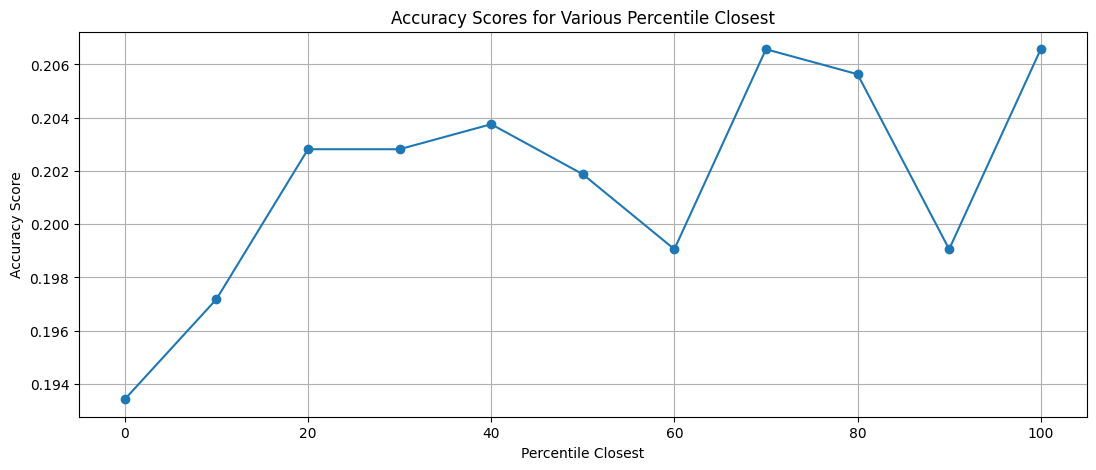

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(percentile_values, accuracy_scores, marker='o', linestyle='-')
plt.title('Accuracy Scores for Various Percentile Closest')
plt.xlabel('Percentile Closest')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

## K = 25

### Step 0

What does Logistic Regression predict in supervised learning?

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
log_reg = LogisticRegression()
log_reg.fit(d2_train, train_labels)

score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression on the whole dataset =", score)

Raw score on logistic regression on the whole dataset = 0.4028169014084507


### Step 1
Let’s train a Logistic Regression model on a sample of 25 labeled instances from the digits dataset. What is the performance of this model on the test set?
The accuracy is just 54.33%. It should come as no surprise that this is much lower than earlier, when we trained the model on the full training set.


In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
n_labeled = 25
log_reg = LogisticRegression()
log_reg.fit(d2_train[:n_labeled], train_labels[:n_labeled])

LogisticRegression()

In [ ]:
score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression on only 25 training examples =", score)

Raw score on logistic regression on only 25 training examples = 0.1568075117370892


### Step 2
Let’s see how we can do better. First, let’s cluster the training set into 25 clusters. Then for each cluster, let’s find the image closest to the centroid. We will call these images the representative images:

In [ ]:
kmeans = KMeans(n_clusters=25)
X_digits_dist = kmeans.fit_transform(d2_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = d2_train[representative_digit_idx]

### Step 3
Let’s look at each image and manually label it:

In [ ]:
y_representative_digits = train_labels[representative_digit_idx] #class_names = [0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
                                                                               # 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot']

### Step 4
Now we have a dataset with just 50 labeled instances, but instead of being random instances, each of them is a representative image of its cluster. Let’s see if the performance is any better.


By utilizing representative images from clusters as labeled instances in the training dataset instead of random samples, the performance of the model can be improved. These representative images are carefully selected to encapsulate the essential characteristics and variations within each cluster, serving as more informative prototypes for their respective groups.

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_representative_digits, y_representative_digits)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after using the representative images for training:", score)

Accuracy score after using the representative images for training: 0.17464788732394365


### Step 5
what if we propagated the labels to all the other instances in the same cluster? This is called label propagation:

We propagate the labels of representative digits to all instances within the same cluster obtained through K-Means clustering.  

Then, we train the model again and look at its performance:

In [ ]:
y_train_propagated = np.empty(len(d2_train), dtype=np.int32)
for i in range(25):
  y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
log_reg = LogisticRegression()
log_reg.fit(d2_train, y_train_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating (completely) the representative images for training:", score)

Accuracy score after propagating (completely) the representative images for training: 0.1643192488262911


### Step 6
We propagated each representative instance’s label to all the instances in the same cluster, including the instances located close to the cluster boundaries, which are more likely to be mislabeled. Let’s see what happens if we only propagate the labels to the 20% of the instances that are closest to the centroids:

In [ ]:
percentile_closest = 40
X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
for i in range(25):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  X_cluster_dist[in_cluster & above_cutoff] = -1
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = d2_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating 40% of the representative images for training:", score)

Accuracy score after propagating 40% of the representative images for training: 0.16056338028169015


### Plot of Accuracy Scores for various values of percentile_values

In [ ]:
percentile_values = np.arange(0, 101, 10)  # Percentile values from 1 to 100 with steps of 10
accuracy_scores = []

for percentile_closest in percentile_values:
    X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
    for i in range(25):
        in_cluster = (kmeans.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1
    partially_propagated = (X_cluster_dist != -1)
    X_train_partially_propagated = d2_train[partially_propagated]
    y_train_partially_propagated = y_train_propagated[partially_propagated]

    log_reg = LogisticRegression()
    log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

    score = log_reg.score(d2_test, test_labels)
    accuracy_scores.append(score)

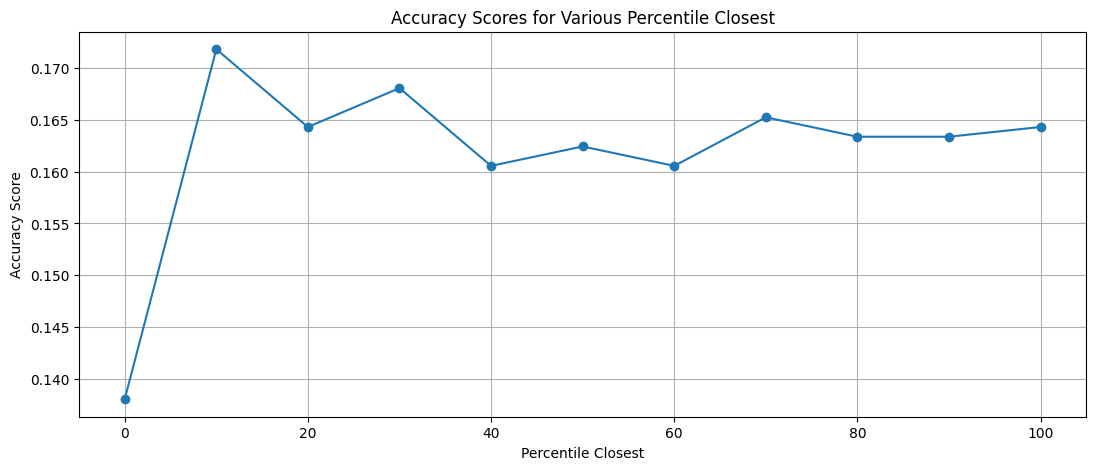

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(percentile_values, accuracy_scores, marker='o', linestyle='-')
plt.title('Accuracy Scores for Various Percentile Closest')
plt.xlabel('Percentile Closest')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

## K = 10

### Step 0

What does Logistic Regression predict in supervised learning?

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
log_reg = LogisticRegression()
log_reg.fit(d2_train, train_labels)

score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression on the whole dataset =", score)

Raw score on logistic regression on the whole dataset = 0.4028169014084507


### Step 1
Let’s train a Logistic Regression model on a sample of 10 labeled instances from the digits dataset. What is the performance of this model on the test set?
The accuracy is just 36.37%. It should come as no surprise that this is much lower than earlier, when we trained the model on the full training set.


In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
n_labeled = 10
log_reg = LogisticRegression()
log_reg.fit(d2_train[:n_labeled], train_labels[:n_labeled])

LogisticRegression()

In [ ]:
score = log_reg.score(d2_test, test_labels)
print("Raw score on logistic regression on only 10 training examples =", score)

Raw score on logistic regression on only 10 training examples = 0.13708920187793427


### Step 2
Let’s see how we can do better. First, let’s cluster the training set into 25 clusters. Then for each cluster, let’s find the image closest to the centroid. We will call these images the representative images:

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
kmeans = KMeans(n_clusters=10)
X_digits_dist = kmeans.fit_transform(d2_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = d2_train[representative_digit_idx]

### Step 3
Let’s look at each image and manually label it:

In [ ]:
y_representative_digits = train_labels[representative_digit_idx] #class_names = [0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
                                                                               # 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot']

### Step 4
Now we have a dataset with just 50 labeled instances, but instead of being random instances, each of them is a representative image of its cluster. Let’s see if the performance is any better.


By utilizing representative images from clusters as labeled instances in the training dataset instead of random samples, the performance of the model can be improved. These representative images are carefully selected to encapsulate the essential characteristics and variations within each cluster, serving as more informative prototypes for their respective groups.

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_representative_digits, y_representative_digits)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after using only the representative images for training:", score)

Accuracy score after using only the representative images for training: 0.09859154929577464


### Step 5
what if we propagated the labels to all the other instances in the same cluster? This is called label propagation:

We propagate the labels of representative digits to all instances within the same cluster obtained through K-Means clustering.  

Then, we train the model again and look at its performance:

In [ ]:
y_train_propagated = np.empty(len(d2_train), dtype=np.int32)
for i in range(10):
  y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
log_reg = LogisticRegression()
log_reg.fit(d2_train, y_train_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating (completely) the representative images for training:", score)

Accuracy score after propagating (completely) the representative images for training: 0.10234741784037558


### Step 6
We propagated each representative instance’s label to all the instances in the same cluster, including the instances located close to the cluster boundaries, which are more likely to be mislabeled. Let’s see what happens if we only propagate the labels to the 40% of the instances that are closest to the centroids:

In [ ]:
percentile_closest = 40
X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
for i in range(10):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  X_cluster_dist[in_cluster & above_cutoff] = -1
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = d2_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
score = log_reg.score(d2_test, test_labels)
print("Accuracy score after propagating 40% of the representative images for training:", score)

Accuracy score after propagating 40% of the representative images for training: 0.1136150234741784


### Plot of Accuracy Scores for various values of percentile_values

In [ ]:
percentile_values = np.arange(0, 101, 10)  # Percentile values from 1 to 100 with steps of 10
accuracy_scores = []

for percentile_closest in percentile_values:
    X_cluster_dist = X_digits_dist[np.arange(len(d2_train)), kmeans.labels_]
    for i in range(10):
        in_cluster = (kmeans.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1
    partially_propagated = (X_cluster_dist != -1)
    X_train_partially_propagated = d2_train[partially_propagated]
    y_train_partially_propagated = y_train_propagated[partially_propagated]

    log_reg = LogisticRegression()
    log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

    score = log_reg.score(d2_test, test_labels)
    accuracy_scores.append(score)

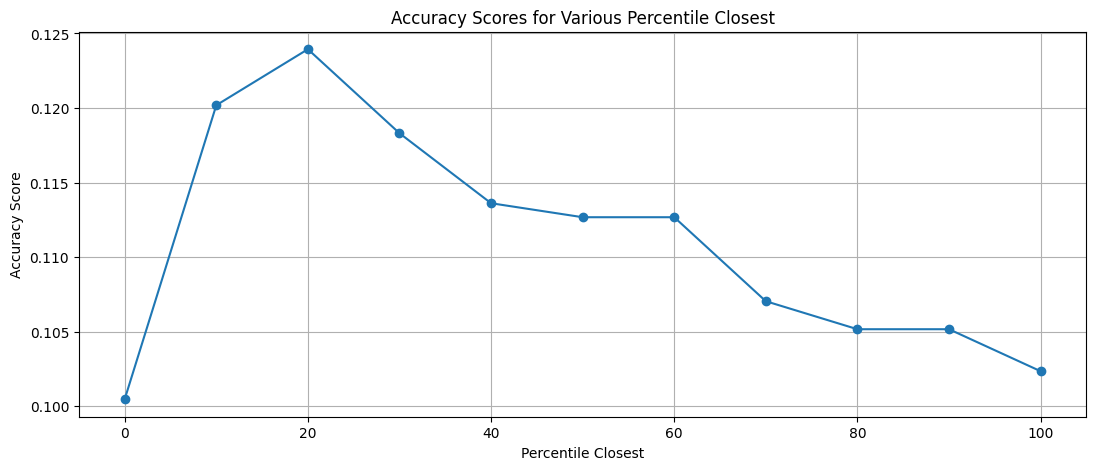

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(percentile_values, accuracy_scores, marker='o', linestyle='-')
plt.title('Accuracy Scores for Various Percentile Closest')
plt.xlabel('Percentile Closest')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()